# **Predict Flight Delays**

In [1]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=28f23ed41134a3a3d553705d9db8e4038278f1e235d0a9e00060ac30e28ee4f7
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


## **Import Libraries**

In [2]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,StandardScaler
from pyspark.ml.pipeline import PipelineModel

sns.set()

spark = SparkSession.builder.appName('FinalProject') .config("spark.driver.memory", "50g") .config("spark.executor.memory", "50g") .getOrCreate()
spark

Mounted at /content/drive


## **Read Dataset**

In [3]:
PATH = '/content/drive/MyDrive/PREDICT/'

In [4]:
# Read dataset.csv
data = spark.read.csv(PATH+'Dataset/train_balanced.csv', header=True, inferSchema=True)
data.printSchema()
data.show(20,False)
data.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- LABEL: double (nullable = true)

+--------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|ID                        |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/10/2023_AA_PHL_BOS_1514 |2      |6    |10          |6          |AA               |PHL   |BOS |280.0   |1729.0      |0.0  |
|1/8/2023_DL_ATL_RIC_1731  |1      |1    |8  

2586600

## **Prepare data**

In [5]:
train, test = data.randomSplit(weights=[0.8,0.2], seed=2024)

In [6]:
train.printSchema()
train.show()
train.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- LABEL: double (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|1/1/2023_9E_JFK_B...|      1|    1|           1|          7|               9E|   JFK| BUF|   301.0|      1645.0|  0.0|
|1/1/2023_9E_MIA_T...|      1|    1|           1|          7|        

2069218

In [7]:
test.printSchema()
test.show()
test.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- LABEL: double (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|1/1/2023_AA_CLT_J...|      1|    1|           1|          7|               AA|   CLT| JFK|   541.0|       711.0|  1.0|
|1/1/2023_AA_DFW_B...|      1|    1|           1|          7|        

517382

<ipython-input-8-9d3700860107>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


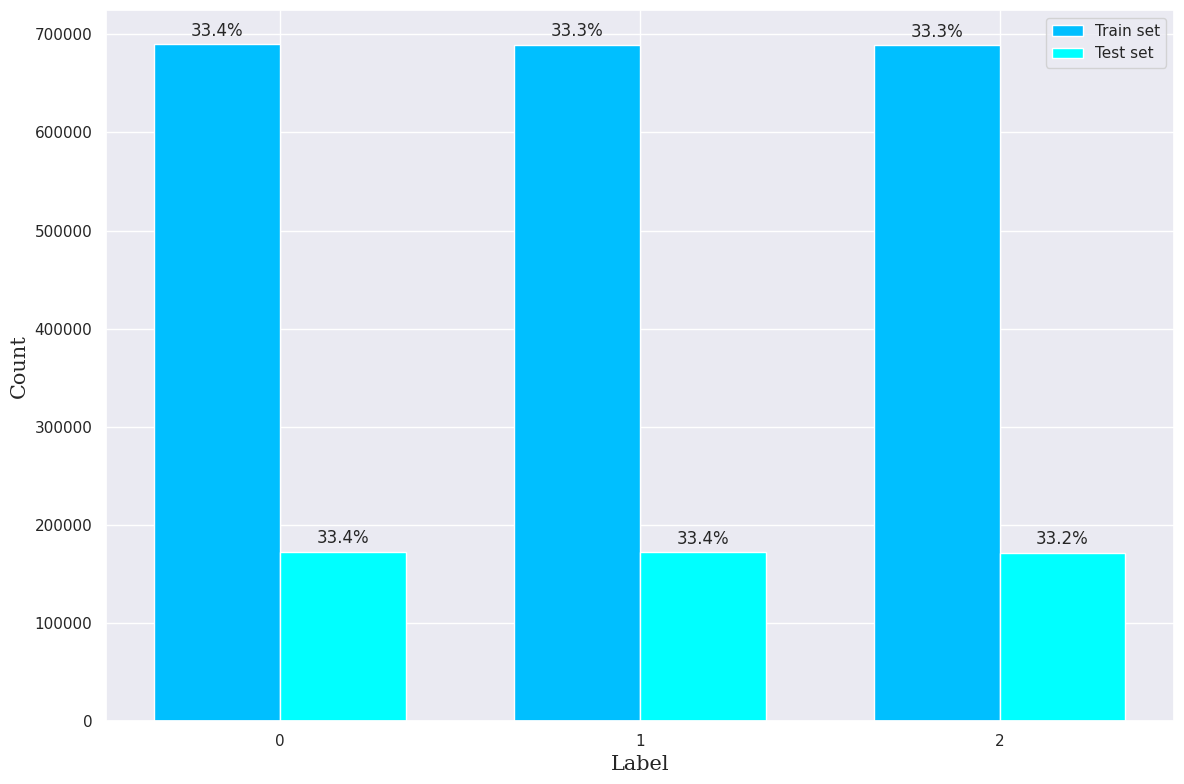

In [8]:
df_train = train.select('LABEL').toPandas()
df_test = test.select('LABEL').toPandas()

label_train = list(df_train.LABEL.value_counts())
label_test = list(df_test.LABEL.value_counts())

rate_train = [round(x * 100 / sum(label_train), 1) for x in label_train]
rate_test = [round(x * 100 / sum(label_test), 1) for x in label_test]

labels = ['G1', 'G2', 'G3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(x - width/2, label_train, width, label='Train set', color ='#00BFFF')
rects2 = ax.bar(x + width/2, label_test, width, label='Test set', color ='#00FFFF')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xticklabels(labels)
ax.legend()

def autolabel_train(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_train[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel_test(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_test[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_train(rects1)
autolabel_test(rects2)
# Adding Xticks
plt.xlabel('Label', fontsize = 15, fontfamily='serif')
plt.ylabel('Count', fontsize = 15, fontfamily='serif')
plt.xticks([r for r in range(len(label_train))], ['0', '1', '2'])
fig.tight_layout()
plt.show()

## **Build & Evaluation Model**

### Logistic Regression

#### Training model

In [9]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [10]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [11]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [12]:
LR = LogisticRegression(featuresCol='features',labelCol='LABEL')

In [13]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, LR])

In [14]:
%%time
model_LR = pipeline.fit(train)

CPU times: user 405 ms, sys: 67.5 ms, total: 473 ms
Wall time: 1min 22s


#### Evaluation model

##### Train

In [15]:
Trained = model_LR.transform(train)
Trained.show(truncate=False)
Trained.count()

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+----------------------------------------------------------------------------+----------------------------------------------------------------+-------------------------------------------------------------+----------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|ORIGINVec       |DESTVec         |features                                                                    |rawPrediction                                                   |probability                                                  |prediction|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----

2069218

In [16]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|790585|
|       1.0|580809|
|       2.0|697824|
+----------+------+



In [17]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.4827    0.5528    0.5153    690309
           1     0.4570    0.3849    0.4179    689544
           2     0.4488    0.4543    0.4516    689365

    accuracy                         0.4640   2069218
   macro avg     0.4628    0.4640    0.4616   2069218
weighted avg     0.4628    0.4640    0.4616   2069218



In [18]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 46.40497%
F1-Micro: 46.40497%
F1-Macro: 46.15988%


##### Test

In [19]:
Tested = model_LR.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_AA_CLT_J...|      1|    1|           1|          7|               AA|   CLT| JFK|   541.0|       711.0

517382

In [20]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|197394|
|       1.0|145670|
|       2.0|174318|
+----------+------+



In [21]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.4807    0.5520    0.5139    171891
           1     0.4577    0.3861    0.4189    172656
           2     0.4494    0.4532    0.4513    172835

    accuracy                         0.4637    517382
   macro avg     0.4626    0.4638    0.4614    517382
weighted avg     0.4626    0.4637    0.4613    517382



In [22]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 46.36651%
F1-Micro: 46.36651%
F1-Macro: 46.13578%


#### Save & Load model

In [23]:
model_LR.write().overwrite().save(PATH+'Model/LR')

In [24]:
model_LR_load = PipelineModel.load(PATH+'Model/LR')

### Decision Tree

#### Training model

In [25]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [26]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [27]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [28]:
DT = DecisionTreeClassifier(maxDepth=16,featuresCol='features',labelCol='LABEL')#

In [29]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, DT])

In [30]:
%%time
model_DT = pipeline.fit(train)

CPU times: user 4.14 s, sys: 648 ms, total: 4.79 s
Wall time: 13min 54s


#### Evaluation model

##### Train

In [31]:
Trained = model_DT.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|       ORIGINVec|         DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_JFK_B...|      1|    1|           1|          7|               9E|   JFK| BUF|   301.0|      1645.0|  0.0

2069218

In [32]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|818024|
|       1.0|500398|
|       2.0|750796|
+----------+------+



In [33]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.5239    0.6208    0.5682    690309
           1     0.5057    0.3670    0.4253    689544
           2     0.5085    0.5538    0.5302    689365

    accuracy                         0.5139   2069218
   macro avg     0.5127    0.5138    0.5079   2069218
weighted avg     0.5127    0.5139    0.5079   2069218



In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 51.38772%
F1-Micro: 51.38772%
F1-Macro: 50.78890%


##### Test

In [35]:
Tested = model_DT.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_AA_CLT_J...|      1|    1|           1|          7|               AA|   CLT| JFK|   541.0|       711.0

517382

In [36]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|204415|
|       1.0|125155|
|       2.0|187812|
+----------+------+



In [37]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.5008    0.5955    0.5440    171891
           1     0.4680    0.3392    0.3933    172656
           2     0.4881    0.5304    0.5084    172835

    accuracy                         0.4882    517382
   macro avg     0.4856    0.4884    0.4819    517382
weighted avg     0.4856    0.4882    0.4818    517382



In [38]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 48.82292%
F1-Micro: 48.82292%
F1-Macro: 48.19093%


#### Save & Load model

In [39]:
model_DT.write().overwrite().save(PATH+'Model/DT')

In [40]:
model_DT_load = PipelineModel.load(PATH+'Model/DT')

### Random Forest

#### Training model

In [41]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [42]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [43]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [44]:
RF = RandomForestClassifier(maxDepth=10, numTrees = 3, featuresCol='features', labelCol='LABEL')#

In [45]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, RF])

In [46]:
%%time
model_RF = pipeline.fit(train)

CPU times: user 706 ms, sys: 94 ms, total: 800 ms
Wall time: 2min 8s


#### Evaluation model

##### Train

In [47]:
Trained = model_RF.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|       ORIGINVec|         DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_JFK_B...|      1|    1|           1|          7|               9E|   JFK| BUF|   301.0|      1645.0|  0.0

2069218

In [48]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1037878|
|       1.0| 457126|
|       2.0| 574214|
+----------+-------+



In [49]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.4249    0.6388    0.5103    690309
           1     0.4383    0.2905    0.3494    689544
           2     0.4454    0.3710    0.4048    689365

    accuracy                         0.4335   2069218
   macro avg     0.4362    0.4335    0.4215   2069218
weighted avg     0.4362    0.4335    0.4216   2069218



In [50]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 43.35333%
F1-Micro: 43.35333%
F1-Macro: 42.15281%


##### Test

In [51]:
Tested = model_RF.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_AA_CLT_J...|      1|    1|           1|          7|               AA|   CLT| JFK|   541.0|       711.0

517382

In [52]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|259619|
|       1.0|114453|
|       2.0|143310|
+----------+------+



In [53]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.4234    0.6396    0.5095    171891
           1     0.4404    0.2920    0.3511    172656
           2     0.4452    0.3691    0.4036    172835

    accuracy                         0.4332    517382
   macro avg     0.4364    0.4336    0.4214    517382
weighted avg     0.4364    0.4332    0.4213    517382



In [54]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 43.32273%
F1-Micro: 43.32273%
F1-Macro: 42.14325%


#### Save & Load model

In [55]:
model_RF.write().overwrite().save(PATH+'Model/RF')

In [56]:
model_RF_load = PipelineModel.load(PATH+'Model/RF')

### Naive Bayes

#### Training model

In [57]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [58]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [59]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [60]:
NB = NaiveBayes(featuresCol='features',labelCol='LABEL',smoothing=0.0003,modelType="multinomial")#

In [61]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, NB])

In [62]:
%%time
model_NB = pipeline.fit(train)

CPU times: user 112 ms, sys: 17.1 ms, total: 129 ms
Wall time: 18.1 s


#### Evaluation model

##### Train

In [63]:
Trained = model_NB.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|       ORIGINVec|         DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_9E_JFK_B...|      1|    1|           1|          7|               9E|   JFK| BUF|   301.0|      1645.0|  0.0

2069218

In [64]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0| 671132|
|       1.0| 248478|
|       2.0|1149608|
+----------+-------+



In [65]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.4032    0.3920    0.3975    690309
           1     0.3880    0.1398    0.2056    689544
           2     0.3602    0.6008    0.4504    689365

    accuracy                         0.3775   2069218
   macro avg     0.3838    0.3775    0.3512   2069218
weighted avg     0.3838    0.3775    0.3512   2069218



In [66]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 37.75078%
F1-Micro: 37.75078%
F1-Macro: 35.11597%


##### Test

In [67]:
Tested = model_NB.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|1/1/2023_AA_CLT_J...|      1|    1|           1|          7|               AA|   CLT| JFK|   541.0|       711.0

517382

In [68]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|167399|
|       1.0| 62110|
|       2.0|287873|
+----------+------+



In [69]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.4028    0.3923    0.3975    171891
           1     0.3901    0.1403    0.2064    172656
           2     0.3622    0.6032    0.4526    172835

    accuracy                         0.3787    517382
   macro avg     0.3850    0.3786    0.3522    517382
weighted avg     0.3850    0.3787    0.3521    517382



In [70]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 37.86661%
F1-Micro: 37.86661%
F1-Macro: 35.21600%


#### Save & Load model

In [71]:
model_NB.write().overwrite().save(PATH+'Model/NB')

In [72]:
model_NB_load = PipelineModel.load(PATH+'Model/NB')